## Рынок заведений общественного питания Москвы

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке

### Цель:

Подготовить исследование рынка на основе открытых данных о заведениях общественного питания в Москве

### Шаг 1. Импорт библиотек и данных.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats

##### Выгружаем данные о заведениях общественного питания Москвы.

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')  
rest_data

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


### Вывод

Нам представлена информация о 15 366 заведениях, по каждому из которых известно:
- id
- название
- сетевое ли заведение
- тип объекта
- адрес
- количество посадочных мест

Тип данных столбцов id и chain следует изменить.

### Шаг 2. Предобработка данных.

##### Замена типа данных

In [4]:
rest_data['id']=rest_data['id'].astype('uint64')

##### Поиск дубликатов

In [5]:
rest_data.duplicated().sum()

0

Полных дубликатов, если считать, что id - показатель уникальности заведения, в данных нет, поэтому приступим к приведению названий заведений к одному виду:

In [6]:
rest_data['object_name'].nunique() 

10393

In [7]:
rest_data['object_name']=rest_data['object_name'].str.lower() #приводим к нижнему регистру

In [9]:
rest_data['object_name']=(rest_data['object_name']
                          .replace({'[A-zА-я -]+«': "«",
                                    "«": "",
                                    "»": "",
                                    "стол.": "столовая",
                                   "dominos pizza":"домино'с пицца",
                                   "krispy creme":"krispy kreme",
                                   "пицца хат":"pizza hut",
                                   "prime cafe":"прайм стар",
                                   "[A-zА-я -]+(прайм)[A-zА-я -]+":"прайм стар",
                                   "[A-zА-я -]+(шоколадница)[A-zА-я -]+":"шоколадница",
                                   "сабвей":"subway",
                                   "coffe":"coffee",
                                   "октябрьская":"",
                                   "корчма":"",
                                   ". экспрессо и капучино бар":"",
                                   "[A-zА-я -]+(му-му)":"му-му",
                                   "[A-zА-я -]+(старина миллер)":"старина миллер",
                                   "[A-zА-я -]+(ян примус)":"ян примус",
                                   "[A-zА-я -]+(макдоналдс)":"макдоналдс",
                                   "(kfc)[A-zА-я -]+":"kfc",
                                    "[A-zА-я -]+(kfc)":"kfc",
                                    "[A-zА-я -]+(starbucks)":"starbucks",
                                    "кулинарная лавка братьев караваевых":"братья караваевы",
                                    "братья караваевых":"братья караваевы",
                                    "кафе":"",
                                    "ресторан":"",
                                    "бар":"",
                                    "[A-zА-я -]+(гудман)":"гудман",
                                    "(white rabbite)[A-zА-я -()]+":"white rabbite",
                                   "(чайхона №1)[A-zА-я -]+":"чайхона №1",
                                   "[A-zА-я -]+(урюк)":"урюк",
                                   "[A-zА-я -]+(милти)":"милти"}, regex = True) #приводим написание названия к одному виду
)

In [10]:
rest_data['object_name'].nunique()

9319

- С помощью приведения к нижнему регистру и регулярных выражений удалось сократить количество "криво" написанных названий на 1 074 (10 393 против 9 319).
- Основные крупные заведения таким образом удалось почистить.

 Конечно тут лучше использовать нечеткий поиск на основе вычисления расстояния Дамерау-Левенштейна, но я, честно, не смогла в нем разобраться и применить к нашим даным.


##### Приведение типа объекта у одинаковых заведений к одному виду

Возьмем моду для каждой группы объектов и запишем ее в новый столбец.

In [11]:
new_objects=rest_data[['object_name','object_type']].copy()
new_objects=new_objects.groupby(['object_name'],as_index=False).agg(lambda x: stats.mode(x)[0][0])


In [12]:
rest_objects=pd.merge(rest_data, new_objects, how='left', on = 'object_name')
rest_objects.rename(columns={'object_type_x': 'object_type_old', 'object_type_y': 'object_type_new'}, inplace=True)
rest_objects.head(20)

,id,object_name,chain,object_type_old,address,number,object_type_new
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,кафе
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,кафе
2,24309,академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,кафе
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,кафе
4,119365,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе
5,27429,столовая при гоу сош № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240,столовая
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,кафе
7,20957,буфет мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90,столовая
8,20958,кпф семья-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150,столовая
9,28858,столоваявая мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120,столовая


### Шаг №2. Анализ данных

##### Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

<BarContainer object of 9 artists>

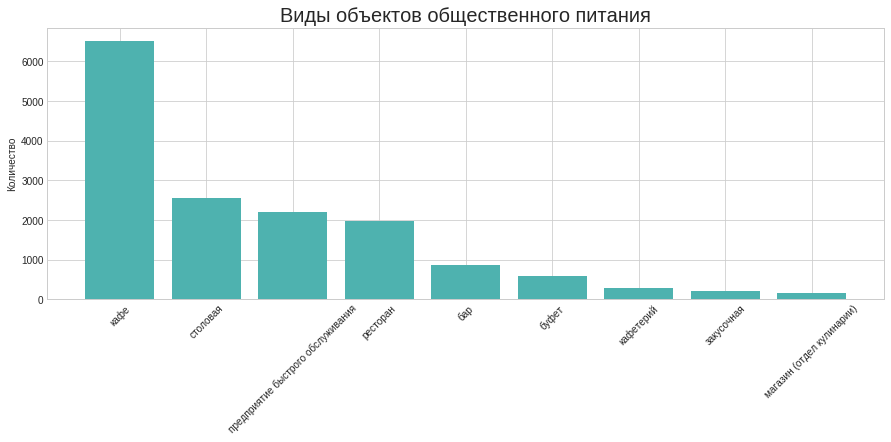

In [15]:
objects=rest_objects.pivot_table(index='object_type_new', values='chain', aggfunc='count' )
objects.columns=['count']
plt.style.use('seaborn-whitegrid')
plt.subplots(figsize=(15,5))
plt.ylabel('Количество')

plt.title('Виды объектов общественного питания', fontsize=20)
plt.xticks(size=10, rotation=45)
objects=objects.sort_values(by='count', ascending=False)
plt.bar(objects.index,objects['count'], color = '#4eb2af')


### Вывод:

- В представленных данных с большим отрывом лидируют кафе.
- Столовые, предприятия быстрого обслуживания и рестораны также широко представлены в Москве и имеют около 2000 заведений и больше.
- Бары, буфеты, кафетерии, закусочные и отделы калинарии представлены менее чем 1000 заведений в городе.

##### Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

In [16]:
chains = rest_objects.pivot_table(index='chain', values='object_type_new', aggfunc='count' )
chains.columns=['count']
chains['%']=round(chains['count']/chains['count'].sum()*100)
chains

,count,%
chain,,
да,2968,19.0
нет,12398,81.0


<BarContainer object of 2 artists>

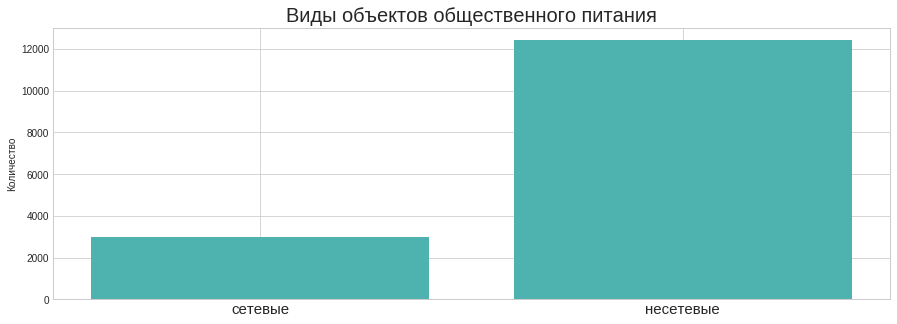

In [17]:
plt.subplots(figsize=(15,5))
plt.ylabel('Количество')
plt.title('Виды объектов общественного питания', fontsize=20)
plt.xticks(np.arange(2), ('сетевые', 'несетевые'), size=15)
plt.bar(chains.index,chains['count'], color = '#4eb2af')

([<matplotlib.patches.Wedge at 0x7f5c8c6c4a10>,
 [Text(-0.6272751072079714, 0.9036182489731093, 'сетевые'),
  Text(0.6272750226051227, -0.9036183077028392, 'несетевые')],
 [Text(-0.34215005847707525, 0.49288268125805956, '19.3%'),
  Text(0.3421500123300669, -0.4928827132924577, '80.7%')])

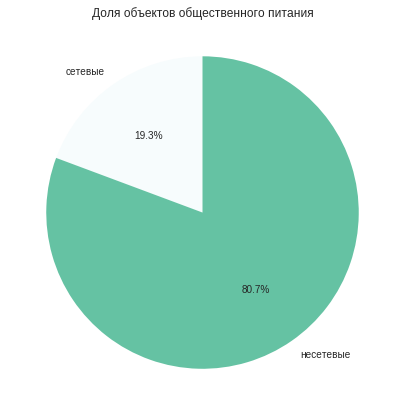

In [18]:
labels = ['сетевые', 'несетевые']
sizes = chains['count']

fig1, ax1 = plt.subplots(figsize=(7,7))

ax1.axis('equal') 
plt.title('Доля объектов общественного питания')
theme = plt.get_cmap("BuGn")
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90) 


### Вывод

- Большинство объектов общественного питания принадлежат к несетевому типу размещения.
- Сетевые объекты занимают всего 19,3% рынка общественного питания Москвы. 

##### Для какого вида объекта общественного питания характерно сетевое распространение?

In [19]:
chain_object=rest_objects.pivot_table(index='object_type_new', columns='chain', values='object_name', aggfunc='count')
chain_object.columns=['сетевые', 'несетевые']
chain_object=chain_object.sort_values(by='сетевые', ascending=False)
chain_object

,сетевые,несетевые
object_type_new,,
кафе,1505.0,5021.0
предприятие быстрого обслуживания,1009.0,1194.0
ресторан,399.0,1565.0
бар,30.0,842.0
кафетерий,10.0,279.0
закусочная,9.0,196.0
магазин (отдел кулинарии),4.0,168.0
буфет,2.0,583.0
столовая,NaN,2550.0


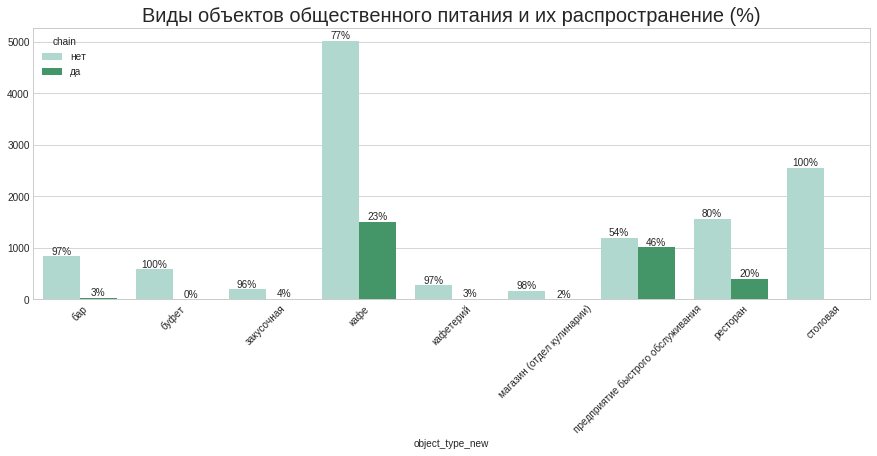

In [22]:
plt.subplots(figsize=(15,5))
plt.title('Виды объектов общественного питания и их распространение (%)', fontsize=20)
plt.xticks(size=10, rotation=45)

order = sorted(rest_objects['object_type_new'].unique())
ax = sns.countplot('object_type_new', data=rest_objects, hue="chain", order=order, palette="BuGn")
ax.set_ylabel('')

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    if height_l==2550.0:
        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(1), ha="center")
    else:
        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")    
        ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")
        

### Вывод

Если смотреть соотношение сетевого/несетевого распространения для каждого типа объекта общественного питания, можно сделать следующие выводы:
- Сетевое распространение характерно для предприятий быстрого обслуживания (46% от общего кол-ва объектов этого типа)
- Сети также организуют в типах кафе и ресторан, но гораздо реже (23% и 20% соответственно)

##### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [23]:
rest_chain=rest_objects.query('chain == "да"') #выделим сетевые в отдельный df

In [24]:
rest_chain.query('object_type_new == "бар"')

,id,object_name,chain,object_type_old,address,number,object_type_new
980,139871,-буфет николай,да,бар,"город Москва, Пятницкая улица, дом 53/18, стро...",43,бар
1311,24935,золотая вобла,да,ресторан,"город Москва, улица Покровка, дом 2/1, строение 1",89,бар
1515,24476,зодиак,да,ресторан,"город Москва, Жулебинский бульвар, дом 25",96,бар
1530,20405,world class,да,бар,"город Москва, улица Архитектора Власова, дом 22",25,бар
1678,71038,золотая вобла,да,ресторан,"город Москва, Сокольническая площадь, дом 9",300,бар
3404,19613,азбука вкуса,да,бар,"город Москва, Мичуринский проспект, дом 22, ко...",6,бар
4446,20727,спб,да,бар,"город Москва, улица Новый Арбат, дом 2",70,бар
4698,20558,золотая вобла,да,кафе,"город Москва, Марксистская улица, дом 18/8, ст...",95,бар
5218,20707,золотая вобла,да,бар,"город Москва, улица Сущёвский Вал, дом 9, стро...",120,бар
5929,89387,лето,да,бар,"город Москва, Рязанский проспект, дом 32, корп...",53,бар


In [25]:
rest_chain_all= rest_chain.pivot_table(index='object_name', values='number', aggfunc=({'count', 'sum'}))
rest_chain_all['mean']=round(rest_chain_all['sum']/rest_chain_all['count'])
rest_chain_all.columns=['кол-во заведений', 'общее кол-во посадочных мест', 'усредненное кол-во посадочных мест']

Почистим названия, которые не удалили регулярными выражениями. Предположим, что сеть должна содержать как минимум 2 заведения.

In [26]:
rest_chain_all_new=rest_chain_all[rest_chain_all['кол-во заведений']>=2].copy()

Text(0.5, 0.98, 'Кол-во объектов и посадочных мест в сетевых заведениях без разбивки')

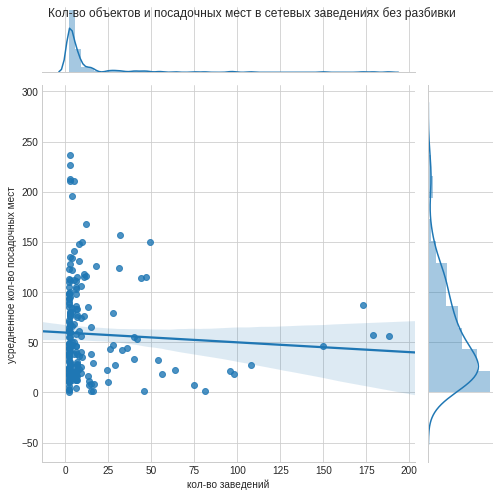

In [27]:
sns.jointplot(x="кол-во заведений", y="усредненное кол-во посадочных мест", data=rest_chain_all_new, kind='reg', height = 7)
plt.suptitle('Кол-во объектов и посадочных мест в сетевых заведениях без разбивки', fontsize = 12)


In [28]:
rest_chain_all_new.describe()

,кол-во заведений,общее кол-во посадочных мест,усредненное кол-во посадочных мест
count,196.000000,196.000000,196.000000
mean,14.081633,741.056122,58.321429
std,28.875923,1774.570056,48.201646
min,2.000000,0.000000,0.000000
25%,2.000000,84.250000,20.750000
50%,4.500000,199.000000,44.000000
75%,9.000000,584.750000,84.250000
max,188.000000,15054.000000,237.000000


Если рассматривать заведения совокупно:
- отсутствует зависимость между количеством заведений и мест в них
- в основном в сеть входит до 9 заведений с количеством посадочных мест до 84.

##### Рассмотрим зависимости по каждому из типов объектов.

In [29]:
def seats(data):
    rest_chain1= data.pivot_table(index='object_name', values='number', aggfunc=({'count', 'sum'}))
    rest_chain1['mean']=round(rest_chain1['sum']/rest_chain1['count'])
    rest_chain1.columns=['кол-во заведений', 'общее кол-во посадочных мест', 'усредненное кол-во посадочных мест']
    rest_chain1_new=rest_chain1[rest_chain1['кол-во заведений']>=2]
    sns.jointplot(x="кол-во заведений", y="усредненное кол-во посадочных мест", data=rest_chain1_new, kind='reg', height = 7)
    plt.suptitle('Кол-во объектов и посадочных мест в сетевых заведениях указанного типа', fontsize = 12)
    
    print('\033[1m'+'Характеристика объекта питания -', data['object_type_new'].mode()[0],'- по количеству заведений и посадочных мест')
    print('\033[0m'+'=================================================================')
    print(rest_chain1_new.describe())    

Характеристика объекта питания - кафе - по количеству заведений и посадочных мест
       кол-во заведений  общее кол-во посадочных мест  \
count        117.000000                    117.000000   
mean          11.914530                    523.085470   
std           21.728962                   1130.185692   
min            2.000000                     12.000000   
25%            2.000000                     81.000000   
50%            6.000000                    188.000000   
75%            9.000000                    508.000000   
max          179.000000                  10242.000000   

       усредненное кол-во посадочных мест  
count                          117.000000  
mean                            46.341880  
std                             36.098085  
min                              4.000000  
25%                             20.000000  
50%                             38.000000  
75%                             62.000000  
max                            211.000000  


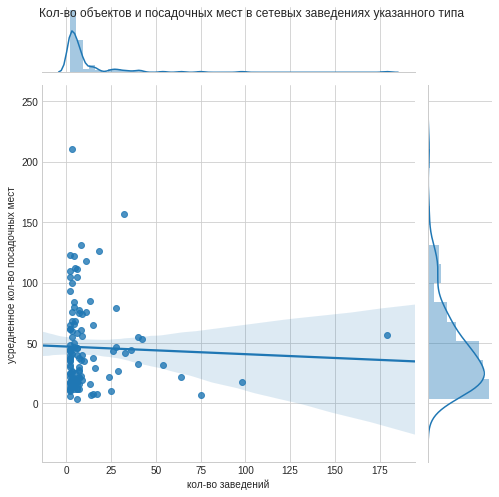

In [30]:
seats(rest_chain.query('object_type_new == "кафе"'))

Характеристика объекта питания - предприятие быстрого обслуживания - по количеству заведений и посадочных мест
       кол-во заведений  общее кол-во посадочных мест  \
count         26.000000                     26.000000   
mean          38.307692                   1551.076923   
std           57.703913                   3667.151057   
min            2.000000                      0.000000   
25%            2.250000                     38.250000   
50%            6.500000                     81.500000   
75%           53.500000                    494.500000   
max          188.000000                  15054.000000   

       усредненное кол-во посадочных мест  
count                           26.000000  
mean                            25.769231  
std                             25.595793  
min                              0.000000  
25%                             11.500000  
50%                             18.000000  
75%                             28.500000  
max                    

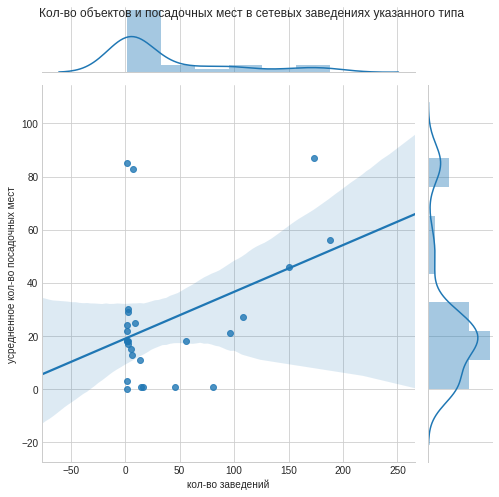

In [31]:
seats(rest_chain.query('object_type_new == "предприятие быстрого обслуживания"'))

Характеристика объекта питания - ресторан - по количеству заведений и посадочных мест
       кол-во заведений  общее кол-во посадочных мест  \
count         43.000000                     43.000000   
mean           8.000000                    978.906977   
std           11.801937                   1550.148485   
min            2.000000                     78.000000   
25%            3.000000                    199.000000   
50%            3.000000                    405.000000   
75%            6.500000                    879.500000   
max           49.000000                   7358.000000   

       усредненное кол-во посадочных мест  
count                           43.000000  
mean                           111.906977  
std                             48.941566  
min                             38.000000  
25%                             79.500000  
50%                            103.000000  
75%                            131.000000  
max                            237.000000  


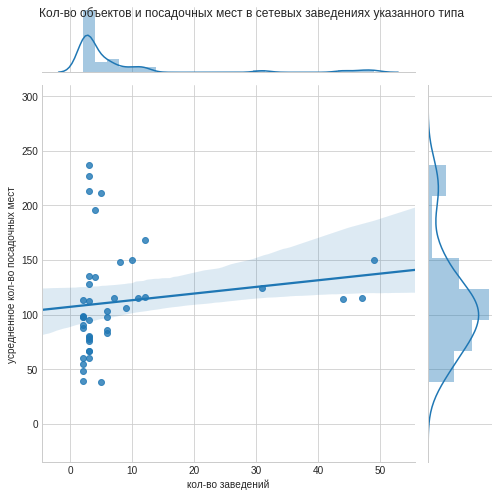

In [32]:
seats(rest_chain.query('object_type_new == "ресторан"'))

In [33]:
rest_chain.query('object_type_new == "магазин (отдел кулинарии)"').head(50)

,id,object_name,chain,object_type_old,address,number,object_type_new
1457,24061,перекресток,да,магазин (отдел кулинарии),"город Москва, Ангелов переулок, дом 7",1,магазин (отдел кулинарии)
1590,24053,билла,да,магазин (отдел кулинарии),"город Москва, Митинская улица, дом 53",1,магазин (отдел кулинарии)
2151,29638,оникс,да,магазин (отдел кулинарии),"город Москва, Планерная улица, дом 14, корпус 1",1,магазин (отдел кулинарии)
12023,173009,мираторг,да,магазин (отдел кулинарии),"город Москва, улица Остоженка, дом 27, корпус 1",12,магазин (отдел кулинарии)


Характеристика объекта питания - бар - по количеству заведений и посадочных мест
       кол-во заведений  общее кол-во посадочных мест  \
count          5.000000                      5.000000   
mean           3.200000                    285.200000   
std            1.643168                    238.275471   
min            2.000000                    140.000000   
25%            2.000000                    144.000000   
50%            2.000000                    188.000000   
75%            5.000000                    250.000000   
max            5.000000                    704.000000   

       усредненное кол-во посадочных мест  
count                            5.000000  
mean                            85.400000  
std                             34.767801  
min                             50.000000  
25%                             70.000000  
50%                             72.000000  
75%                             94.000000  
max                            141.000000  


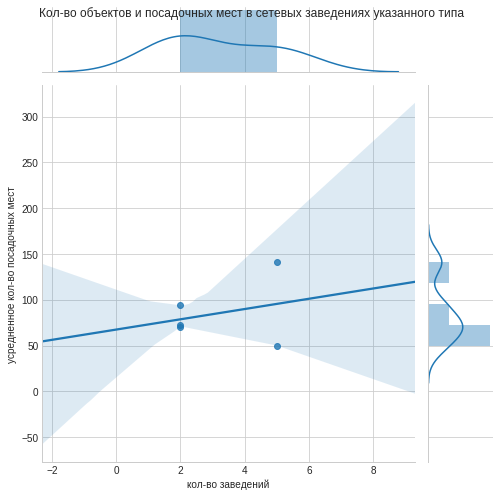

In [34]:
seats(rest_chain.query('object_type_new == "бар"'))

Характеристика объекта питания - кафетерий - по количеству заведений и посадочных мест
       кол-во заведений  общее кол-во посадочных мест  \
count               2.0                      2.000000   
mean                2.0                     27.500000   
std                 0.0                     10.606602   
min                 2.0                     20.000000   
25%                 2.0                     23.750000   
50%                 2.0                     27.500000   
75%                 2.0                     31.250000   
max                 2.0                     35.000000   

       усредненное кол-во посадочных мест  
count                            2.000000  
mean                            14.000000  
std                              5.656854  
min                             10.000000  
25%                             12.000000  
50%                             14.000000  
75%                             16.000000  
max                             18.000000  


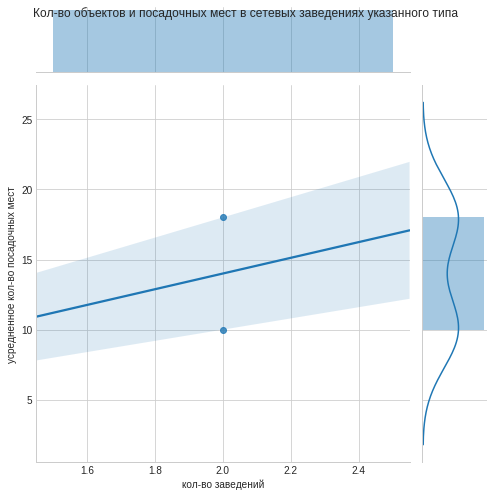

In [35]:
seats(rest_chain.query('object_type_new == "кафетерий"'))

Характеристика объекта питания - закусочная - по количеству заведений и посадочных мест
       кол-во заведений  общее кол-во посадочных мест  \
count               2.0                      2.000000   
mean                2.0                     23.000000   
std                 0.0                     26.870058   
min                 2.0                      4.000000   
25%                 2.0                     13.500000   
50%                 2.0                     23.000000   
75%                 2.0                     32.500000   
max                 2.0                     42.000000   

       усредненное кол-во посадочных мест  
count                            2.000000  
mean                            11.500000  
std                             13.435029  
min                              2.000000  
25%                              6.750000  
50%                             11.500000  
75%                             16.250000  
max                             21.000000  


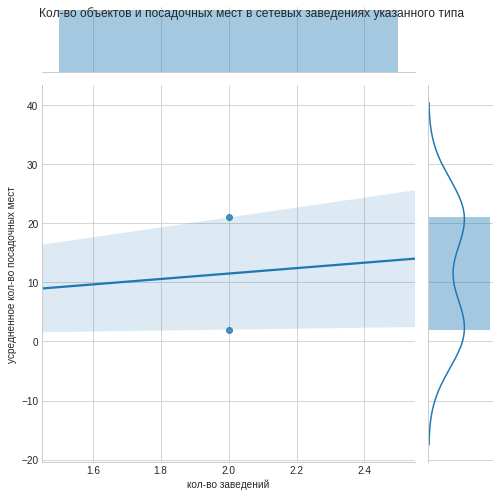

In [36]:
seats(rest_chain.query('object_type_new == "закусочная"'))

Характеристика объекта питания - буфет - по количеству заведений и посадочных мест
       кол-во заведений  общее кол-во посадочных мест  \
count               1.0                           1.0   
mean                2.0                          98.0   
std                 NaN                           NaN   
min                 2.0                          98.0   
25%                 2.0                          98.0   
50%                 2.0                          98.0   
75%                 2.0                          98.0   
max                 2.0                          98.0   

       усредненное кол-во посадочных мест  
count                                 1.0  
mean                                 49.0  
std                                   NaN  
min                                  49.0  
25%                                  49.0  
50%                                  49.0  
75%                                  49.0  
max                                  49.0  


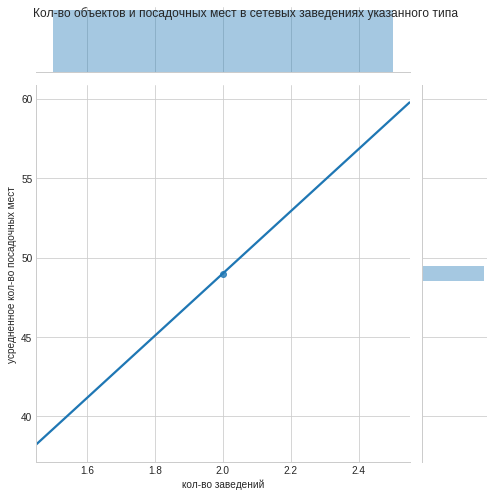

In [37]:
seats(rest_chain.query('object_type_new == "буфет"'))

### Вывод

- По типам заведений зависимость также отсутствует.
- Для кафе характерно не более 9 заведений в сети и не более 62 мест.
- Для предприятий быстрого обслуживания - не более 53 заведений в сети и не более 28 мест.
- Для ресторанов - не более 6 заведений в сети и не более 131 места.


- Отделы кулинарии не подходят под условие минимум 2 заведения в сети.
- Для баров - не более 5 заведений в сети и не более 94 мест.
- Для кафетериев и закусочных - не более 2 заведений в сети и не более 16 мест.
- Буфет в данных только 1 с 2 заведениями и 49 местами.

Видимо данные собирали из опроса пользователей. Сложно как-то иначе объяснить,например, такой разброс по типам заведений.
Объекты типа кулинария, кафетерий, закусочная и буфет я бы не стала рассматривать в таком разрезе. Видимо люди чаще путались именно с этими типами объектов.

##### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

(0, 450)

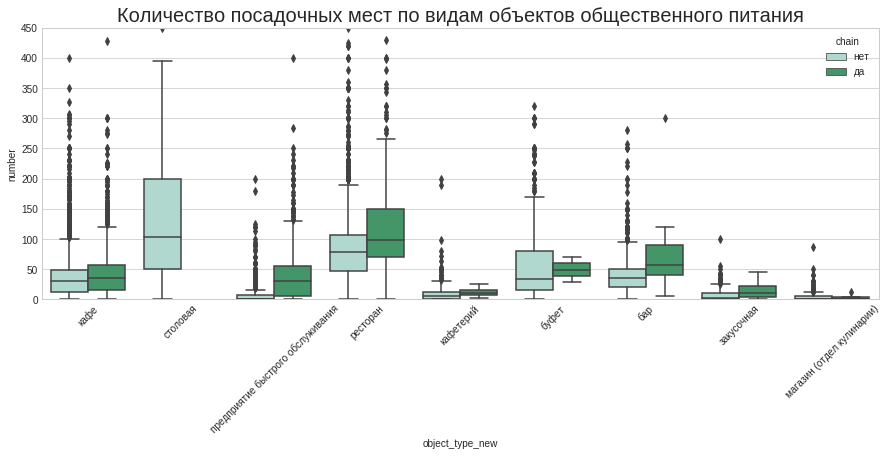

In [38]:
plt.subplots(figsize=(15,5))
plt.title('Количество посадочных мест по видам объектов общественного питания', fontsize=20)
plt.xticks(size=10, rotation=45)
sns.boxplot(x="object_type_new", y="number", hue="chain", data=rest_objects, palette="BuGn").set_ylim(0, 450)

In [39]:
rest_objects.pivot_table(index="object_type_new", values='number',aggfunc='mean').sort_values(by='number', ascending=False)


,number
object_type_new,
столовая,130.270980
ресторан,102.628310
буфет,54.625641
бар,44.552752
кафе,39.270916
предприятие быстрого обслуживания,22.060372
кафетерий,10.830450
закусочная,7.853659
магазин (отдел кулинарии),4.779070


### Вывод

- В среднем наибольшее количество посадочных мест предоставляют столовые (около 130).
- В ресторанах в среднем обустраивают около 100 мест.
- Предприятия быстрого обслуживания, кафе, бары и буфеты предоставляют до 55 мест (22, 39, 45 и 55 соответственно).
- Отделы кулинарии, закусочные и кафетерии обычно не предусматривают большое количество гостей и располагают 4 - 11 посадочными местами в среднем.
- Количество посадочных мест в сетевых заведениях обычно немного выше несетевых аналогов.

##### Выделите в отдельный столбец информацию об улице из столбца address .

In [40]:
streets_names = ['улица','проспект','шоссе','проезд','бульвар','переулок','набережная','площадь','вал','аллея', 'поселение', 'микрорайон', 'тупик', 'квартал']
def street(row):
    address = row['address']
    for i in range(3):
        for row in address.split(', ')[i].split(' '):
            if row in streets_names:
                street = address.split(', ')[i]
                return street
    
            
            
rest_objects['street'] = rest_objects.apply(street, axis = 1)

In [41]:
rest_objects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 8 columns):
id                 15366 non-null uint64
object_name        15366 non-null object
chain              15366 non-null object
object_type_old    15366 non-null object
address            15366 non-null object
number             15366 non-null int64
object_type_new    15366 non-null object
street             15162 non-null object
dtypes: int64(1), object(6), uint64(1)
memory usage: 1.7+ MB


### Вывод

- Из 15 366 адресов выделила 15 162 улицы.
- В список не попал Зеленоград, пару поселков и МКАД. Учитывая описание проекта, кафе с роботами, думаю, что можно отбросить эти адреса.

##### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [42]:
streets_top_10=rest_objects.pivot_table(index='street', values ='object_name', aggfunc='count').reset_index().sort_values(by='object_name', ascending=False).head(10)
streets_top_10

,street,object_name
1419,проспект Мира,204
996,Профсоюзная улица,183
674,Ленинградский проспект,173
980,Пресненская набережная,167
391,Варшавское шоссе,164
677,Ленинский проспект,148
1385,поселение Сосенское,139
1415,проспект Вернадского,132
665,Кутузовский проспект,114
589,Каширское шоссе,112


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

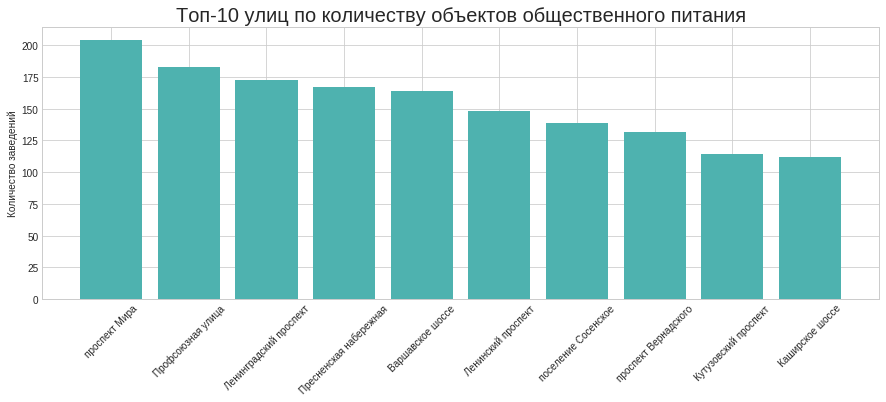

In [43]:
plt.subplots(figsize=(15,5))
plt.ylabel('Количество заведений')
plt.title('Топ-10 улиц по количеству объектов общественного питания', fontsize=20)
plt.bar(streets_top_10['street'], streets_top_10['object_name'], color = '#4eb2af')
plt.xticks(size=10, rotation=45)

### Вывод

- Наибольшее количество объектов питания находится на проспекте Мира, Профсоюзной улице и Ленинградском проспекте (204, 183 и 173 соответственно).
- В 1,5 раза меньше объектов находится на Каширском шоссе и Кутузовском проспекте (112 и 114).

In [44]:
#def get_coordinates(street): #достаем координаты
    #BASE_URL='https://geocode-maps.yandex.ru/1.x'
   
    #params={
        #'apikey':apikey,
        #'format':'xml',
        #'geocode':street
    #}
    #response = requests.get(BASE_URL, params=params)
    #soup=BeautifulSoup(response.text, 'lxml')
    #position=soup.find('pos').text
    #return position
 

#def district(street): #достаем район города
    #try: 
        #coordinates=get_coordinates(street)
        #URL='https://geocode-maps.yandex.ru/1.x'
        #params={"geocode": coordinates, "apikey": apikey, "format": "json", "sco":"longlat", "kind":"district"}
        #response = requests.get(URL, params=params)
        #response.raise_for_status()
        #info_found=response.json()['response']['GeoObjectCollection']['featureMember']
        #most_relevant=info_found[0]
        #district=most_relevant['GeoObject']['name']
        #return district
    #except: 
        #pass #по некоторым улицам падает ошибка вызванная, видимо, отсутствием единой структуры записи адресов. 
             #Например у Варшавского шоссе тип district отсутствует.

In [45]:
#streets_top_10['district']=streets_top_10['street'].apply(district) #применяю функцию выделения района к df
#streets_top_10.to_csv('streets_top_10.csv', index=False) #экспортирую в файл

In [46]:
streets_top_10 = pd.read_csv('streets_top_10.csv')  #загружаю сохраненный файл

In [47]:
streets_top_10=streets_top_10.set_index('street', drop=True)
streets_top_10

,object_name,district
street,,
проспект Мира,204,Алексеевский район
Профсоюзная улица,183,1-й микрорайон
Ленинградский проспект,173,Хорошёвский район
Пресненская набережная,167,Московский международный деловой центр Москва-...
Варшавское шоссе,164,NaN
Ленинский проспект,148,муниципальный округ Дачное
поселение Сосенское,139,квартал № 150
проспект Вернадского,132,Ломоносовский район
Кутузовский проспект,114,район Дорогомилово


В целом представленные улицы достаточно протяженные, районы с массовой жилой и коммерческой застройкой. В них расположено множество торговых и деловых центров.

##### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [48]:
streets_with_one_objects=rest_objects.pivot_table(index='street', values ='object_name', aggfunc='count').query('object_name == 1').reset_index()
streets_with_one_objects.rename(columns={'object_name': 'count'}, inplace=True)
streets_with_one_objects

,street,count
0,1-й Балтийский переулок,1
1,1-й Басманный переулок,1
2,1-й Ботанический проезд,1
3,1-й Вешняковский проезд,1
4,1-й Голутвинский переулок,1
...,...,...
526,улица Шеногина,1
527,улица Шумилова,1
528,улица Шумкина,1
529,улица Щорса,1


In [49]:
#streets_with_one_objects['district']=streets_with_one_objects['street'].apply(district) #применяю функцию выделения района к df
#streets_with_one_objects.to_csv('streets_with_one_objects.csv', index=False) #экспортирую в файл

In [50]:
streets_with_one_objects = pd.read_csv('streets_with_one_objects.csv')  #загружаю сохраненный файл

In [51]:
streets_with_one_objects

,street,count,district
0,1-й Балтийский переулок,1,район Аэропорт
1,1-й Басманный переулок,1,Красносельский район
2,1-й Ботанический проезд,1,район Свиблово
3,1-й Вешняковский проезд,1,14-й квартал Чухлинки
4,1-й Голутвинский переулок,1,район Якиманка
...,...,...,...
526,улица Шеногина,1,район Хорошёво-Мнёвники
527,улица Шумилова,1,район Кузьминки
528,улица Шумкина,1,район Сокольники
529,улица Щорса,1,микрорайон Сельмаш


In [52]:
pivot_one_object=streets_with_one_objects.pivot_table(index='district', values='count', aggfunc='sum').sort_values(by='count', ascending=False)
pivot_one_object.head(10)

,count
district,
Таганский район,25
Басманный район,21
Тверской район,17
район Марьина Роща,16
район Замоскворечье,14
Мещанский район,12
район Сокольники,11
район Якиманка,10
Пресненский район,10


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 <a list of 27 Text xticklabel objects>)

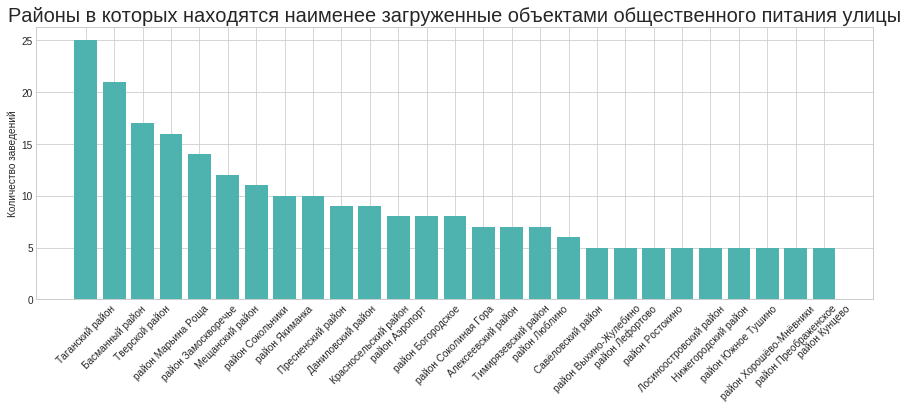

In [53]:
plt.subplots(figsize=(15,5))
plt.ylabel('Количество заведений')
plt.title('Районы в которых находятся наименее загруженные объектами общественного питания улицы', fontsize=20)
plt.bar(pivot_one_object.query('count>4').index, pivot_one_object.query('count>4')['count'], color = '#4eb2af')
plt.xticks(size=10, rotation=45)

### Вывод

Меньшее количество заведений общественного питания в этих районах может быть связано с
- высокой арендной платой (для центра)
- борьбой правительства Москвы за восстановление исторического облика города (когда закрылось множество кафе, возможно их площади пустили под другое назначение)
- парковыми территориями, в которых тяжело получить разрешение на открытие
- промышленными зонами
- малой жилой застройкой

Тут конечно каждый район нужно разбирать отдельно, потому что список очень разношерстный, но, в целом, причины я описала.

##### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [54]:
def category(row):

    if row in streets_top_10.index:
        return 'top_10'
    else:
        return 'other'
    return row

rest_objects['category'] = rest_objects['street'].apply(category)


In [55]:
number_for_top_10=rest_objects.query('category == "top_10"') #выделим категорию топ-10 из df

(0, 300)

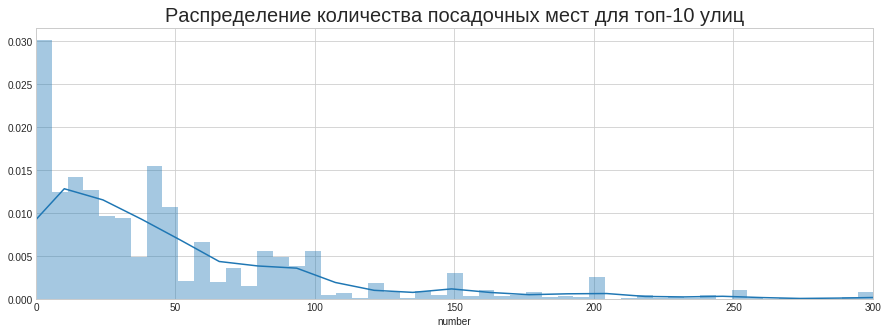

In [56]:
plt.subplots(figsize=(15,5))
plt.title('Распределение количества посадочных мест для топ-10 улиц', fontsize=20)
sns.distplot(number_for_top_10['number'], bins=300).set_xlim(0, 300)

Общее распределение дает некоторые пики которые, мне кажется, стоит рассмотреть подробнее по типам заведений.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

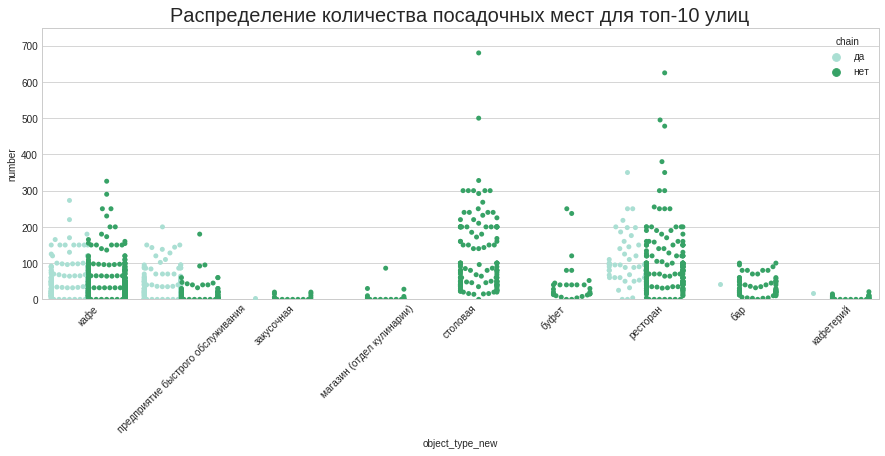

In [57]:
plt.subplots(figsize=(15,5))
plt.ylabel('Количество заведений')
plt.title('Распределение количества посадочных мест для топ-10 улиц', fontsize=20)
sns.swarmplot(x="object_type_new", y="number", hue='chain', data=number_for_top_10, dodge=True, palette="BuGn").set_ylim(0, 750)
plt.xticks(size=10, rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

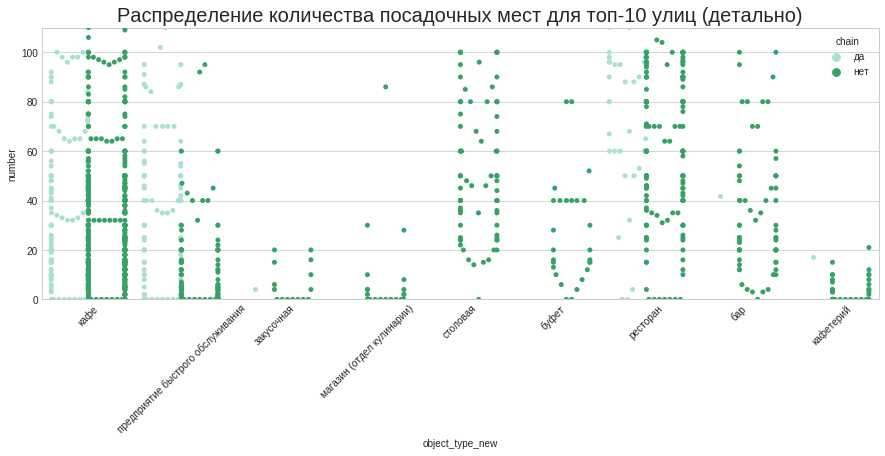

In [58]:
plt.subplots(figsize=(15,5))
plt.ylabel('Количество заведений')
plt.title('Распределение количества посадочных мест для топ-10 улиц (детально)', fontsize=20)
sns.swarmplot(x="object_type_new", y="number", hue='chain', data=number_for_top_10, dodge=True, palette="BuGn").set_ylim(0, 110)
plt.xticks(size=10, rotation=45)

### Вывод

- Во всех типах заведений есть объекты у которых отсутствуют собственные посадочные места. Такие объекты могут располагаться в фуд-кортах.
- На графиках видны горизонтальные линии на количестве примерно в 30, 65 и 80-100 мест. Видимо, в зависимости от размера заведения, это самая популярная посадка.
- Количество мест больше 200 достаточно редко и встречается у столовых, ресторанов и иногда у кафе.

### Общий вывод

#### По итогам анализа представленных данных можно сказать:

- В Москве широко представлены столовые, предприятия быстрого обслуживания и рестораны, но абсолютным лидером по количеству являются заведения типа кафе. 
- Доля несетевых ресторанов составляет 80,7% (12 398 заведений), против всего 19,3% (2 968) сетевых
- Сетевыми чаще являются кафе, предприятия быстрого обслуживания и рестораны. Остальные типы заведений чаще расположены локально и в единичном виде.
- Количество посадочных мест обычно не зависит от количества заведений в сети.
- Среднее количество посадочных мест по объектам: 
  - рестораны и столовые - 100-130 мест
  - предприятия быстрого обслуживания, кафе, бары и буфеты - 22-55 мест
  - отделы кулинарии, закусочные и кафетерии - 4-11 мест
- Наибольшее количество объектов питания находится на проспекте Мира, Профсоюзной улице и Ленинградском проспекте (204, 183 и 173 соответственно). Топ-10 улиц находятся в районах с хорошей проходимостью, обилием деловых и торговых помещений и в непосредственной близости от центра города.
- Наименьшее количество объектов расположено в районах, которые по тем или иным причинам не требуют обилия заведений общественного питания.
- Заведения, имеющие отдельные помещения (располагающиеся не на фуд-кортах) на улицах с большой проходимостью, чаще всего обустраивают 30, 65 или 80-100 мест, в зависимости от размера.
 
#### Учитывая специфику планируемого к открытию заведения(обслуживание роботам), я бы рекомендовала:

- Тип заведение - кафе, несетевого вида. 
- Количество посадочных мест 20-30. 
- Несмотря на обилие заведений в районах расположения топ-10 улиц, считаю что к ним стоит присмотреться. В частности, к Алексеевскому. Думаю, что кафе с такой фишкой будет правильнее расположить в непосредственной близости от мест, связанных с наукой и роботами. Например павильон робототехники на ВДНХ или технополисы Москвы, расположенные на небольшом удалении от центра - ЗИЛ, Сколково. Такие места часто устраивают мероприятия для детей и взрослых и людям будет удобнее зайти в схожее по тематике место для усиления эмоций, чем ехать в абстрактное кафе с роботами на одной из улиц города, в день когда и без того много дел (любой день). 
- Для комментирования развития сети, мне кажется, необходимо составить бизнес-план, открыться, проработать какое-то время, возможно опросить посетителей на предмет удовлетворенности ценами и качествоми и желая видеть подобное заведение в своем районе. В общем провести другое исследование, поскольку речь не об открытии типового кафе, а о кафе со своеобразной фишкой.

### Презентация: https://yadi.sk/i/mAco3vagp7IZsg